In [61]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [62]:
def crop_minAreaRect_with_margin(img, rect, margin=0):
    # Source: https://stackoverflow.com/questions/37177811/

    # Rotate img
    angle = rect[2]
    rows, cols = img.shape[0], img.shape[1]
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rot = cv2.warpAffine(img, matrix, (cols, rows))

    # Rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.intp(cv2.transform(np.array([box]), matrix))[0]
    pts[pts < 0] = 0

    # Add margin to the bounding box coordinates
    pts[:, 0] = np.clip(pts[:, 0], margin, cols - 1 - margin)
    pts[:, 1] = np.clip(pts[:, 1], margin, rows - 1 - margin)

    # Crop and return
    return img_rot[
        pts[1][1] - margin : pts[0][1] + margin, pts[1][0] - margin : pts[2][0] + margin
    ]

dtype: uint8, shape: (122, 120, 3), min: 0, max: 255


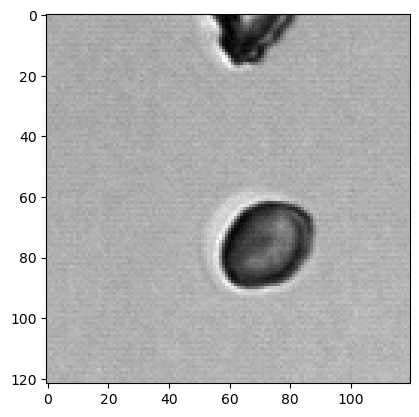

In [63]:
path = "/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/discocyte.tif"
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"

print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, cmap="grey")

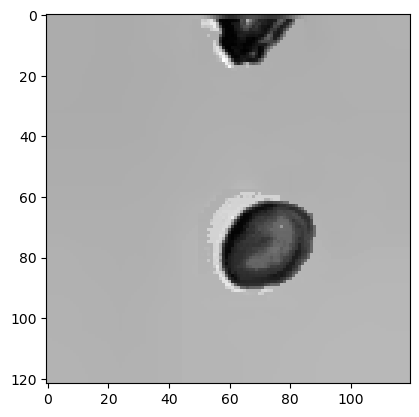

In [73]:
filt = cv2.pyrMeanShiftFiltering(img, sp=10, sr=30, maxLevel=2)
gray_filt = cv2.cvtColor(filt, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_filt, cmap="grey")

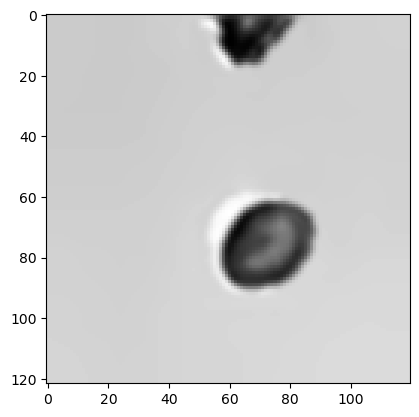

In [65]:
# Smooth image
blur = cv2.GaussianBlur(gray_filt, (5, 5), 0)
plt.imshow(blur, cmap="grey")

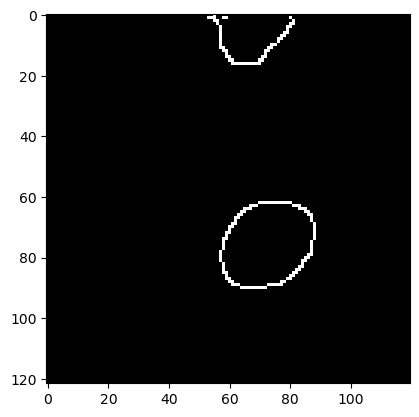

In [77]:
edges = cv2.Canny(blur, threshold1=150, threshold2=200)
plt.imshow(edges, cmap="gray")

In [67]:
# contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

# # temp = cv.drawContours(img, contours, -1, (0,255,0), 3)
# cnt = contours[0]

# temp = cv.drawContours(img, [cnt], 0, (0, 255, 0), 3)
# plt.imshow(temp, cmap="gray")

In [68]:
# _, threshold = cv2.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
# closing = cv.morphologyEx(gray, cv.MORPH_CLOSE, kernel)

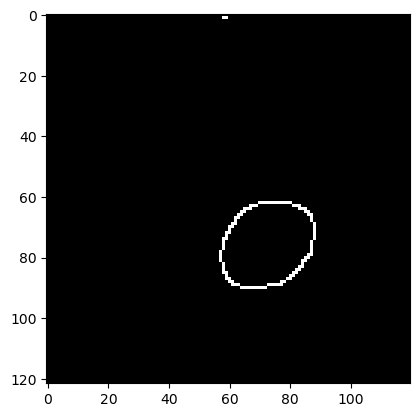

In [78]:
# Remove cells at the border
from skimage.segmentation import clear_border

no_bord = clear_border(edges)
plt.imshow(no_bord, cmap="grey")

In [9]:
# contours, hierarchy = cv2.findContours(no_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# cnt = contours[0]
# # cv2.drawContours(img, [cnt], 0, (0,255,0), 1)
# # plt.imshow(img, cmap="gray")

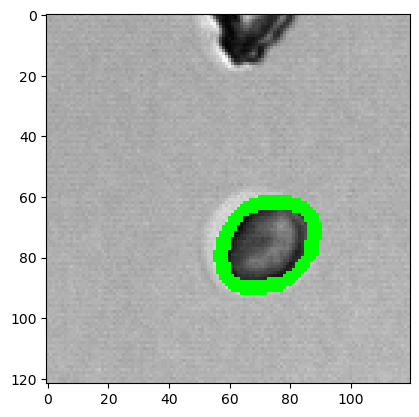

In [83]:
contours, hierarchy = cv2.findContours(no_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
valid_contours = []
for i, (contour, h) in enumerate(zip(contours, hierarchy[0])):
    # Check if the contour is not inside another contour (parent index is -1)
    if h[3] == -1:
        area = cv2.contourArea(contour)
        # Check if the area is less than 1200 pixels
        if (area <= 1200) and (area >= 200):
            valid_contours.append(contour)

    if valid_contours:
        # Randomly select one of the valid contours
        cnt = random.choice(valid_contours)

        img_copy = img.copy()
        cv2.drawContours(img_copy, [cnt], -1, (0, 255, 0), 3)

        plt.imshow(img_copy, cmap="gray")
    else:
        print("No valid contours found.")

In [74]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create a mask of the same size as the image, initialized to black
mask = np.zeros_like(grey)

# Draw the contour on the mask in white
cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

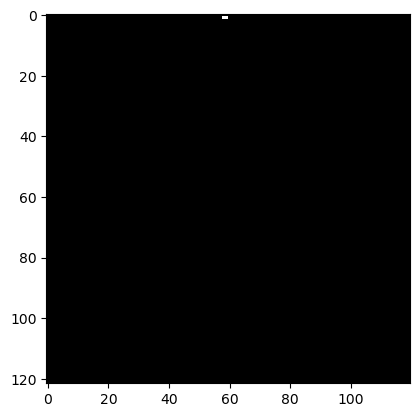

In [76]:
  plt.imshow(mask, cmap="gray")
  plt.show()

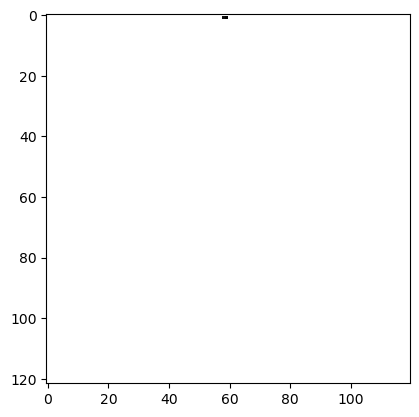

In [75]:
# Invert the mask so that the area outside the contour is white
mask_inv = cv2.bitwise_not(mask)


# Set the outside area to white using the inverted mask
img_copy[mask_inv == 255] = 255

# # Apply brightness adjustment to the whole image
# alpha = 1.7
# beta = 0
# gamma = 0
# bright = cv2.addWeighted(result, alpha, result, beta, gamma)

# Display the result
plt.imshow(img_copy)
plt.show()

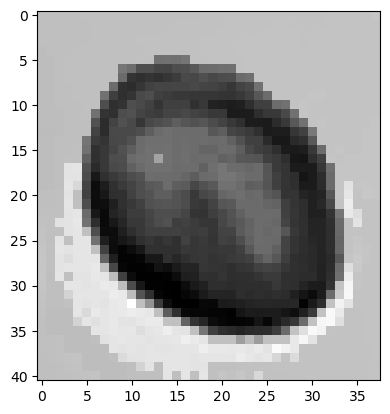

In [50]:
rect = cv2.minAreaRect(cnt)
croped = crop_minAreaRect_with_margin(gray, rect, margin=5)
plt.imshow(croped, cmap="gray")

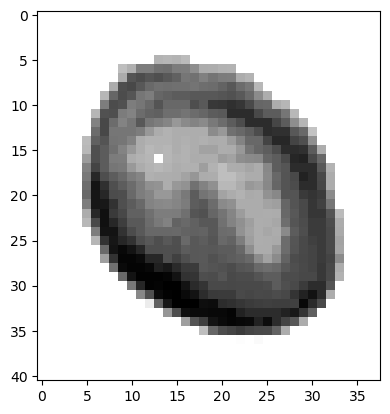

In [36]:
# alpha = 1.7
# beta = 0
# gamma = 0

# bright = cv2.addWeighted(croped, alpha, croped, beta, gamma)

# plt.imshow(bright, cmap="gray")

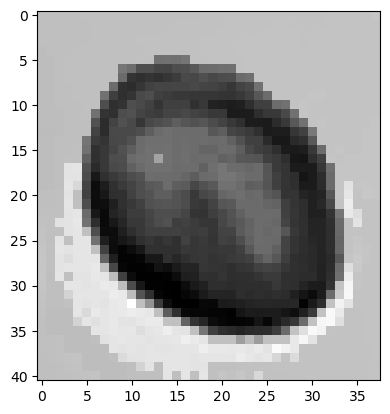

In [ ]:
rect = cv2.minAreaRect(cnt)
croped = crop_minAreaRect_with_margin(gray, rect, margin=5)
plt.imshow(croped, cmap="gray")

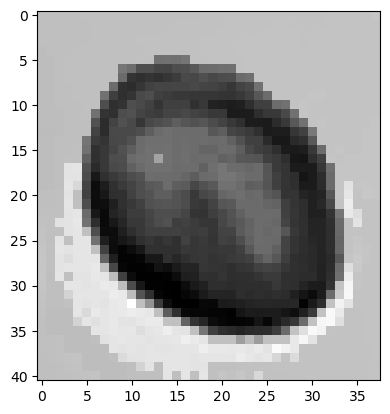

In [ ]:
rect = cv2.minAreaRect(cnt)
croped = crop_minAreaRect_with_margin(gray, rect, margin=5)
plt.imshow(croped, cmap="gray")

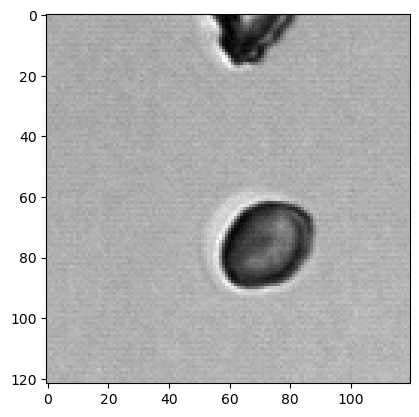

In [41]:
plt.imshow(img, cmap="gray")

In [12]:
def image_resize(image, height=None, inter=cv2.INTER_AREA):
    dimension = None
    (h, w) = image.shape[:2]

    if height is None:
        height = h

    r = height / float(h)  # Resizing ratio
    dimension = (int(w * r), height)

    resized = cv2.resize(image, dimension, interpolation=inter)

    return resized

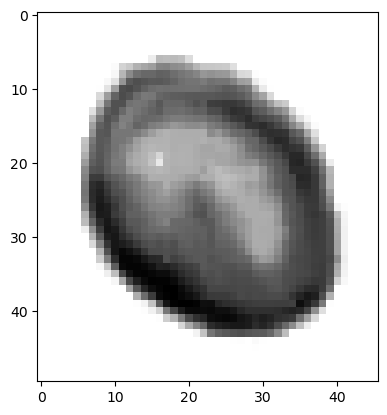

In [13]:
# Resize the image
resized = image_resize(bright, height=50)

plt.imshow(resized, cmap="grey")

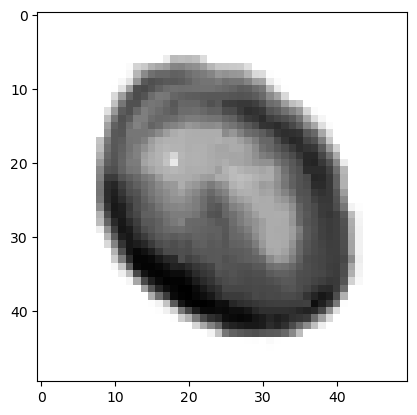

In [14]:
def image_pad(src, bordertype=cv2.BORDER_REPLICATE):
    if resized.shape[0] != resized.shape[1]:
        pad_width = abs(resized.shape[1] - resized.shape[0])

    left = pad_width // 2
    right = pad_width - left
    top = 0
    bottom = 0

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, bordertype)

    return padded


padded = image_pad(resized)
plt.imshow(padded, cmap="grey")

In [28]:
import hashlib


def get_hash_with_randomness(file_path):
    # Generate a random salt
    salt = os.urandom(16)  # 16 bytes of randomness

    # Read the file and compute the hash
    with open(file_path, "rb") as f:
        file_bytes = f.read()  # read entire file as bytes
        bytes_with_salt = file_bytes + salt  # append the salt to the file content
        readable_hash = hashlib.sha256(bytes_with_salt).hexdigest()

    return readable_hash

In [29]:
hash_for_filename = get_hash_with_randomness(path)
print(hash_for_filename)  # This will be your file name

f54670bdd2874db955576d55ea0dce242cd76989cae7174ed9402709703cf58c


In [17]:
my_dict = {}
my_dict.setdefault(readable_hash, [])
my_dict[readable_hash].append(path)

In [19]:
my_dict[readable_hash][0]

'/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/discocyte.tif'